In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

# Data fetching

In [2]:
data_path = './data_yelp/raw/json/yelp_academic_dataset_review.json'
# Reading the first line of the review dataset json
with open(data_path) as f:
    first_line = f.readline()
    print(first_line)

{"review_id":"Q1sbwvVQXV2734tPgoKj4Q","user_id":"hG7b0MtEbXx5QzbzE6C_VA","business_id":"ujmEBvifdJM6h6RLv4wQIg","stars":1.0,"useful":6,"funny":1,"cool":0,"text":"Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.","date":"2013-05-07 04:34:36"}



In [3]:
from data_preprocesser import split_raw_csv_review_file

split_raw_csv_review_file(lines_per_file = 100000, single_file=True, join_business=True)

In [4]:
small_data_path = './data_yelp/preprocessed/yelp_academic_dataset_review_split/yelp_academic_dataset_review_100000.csv'
data_df = pd.read_csv(small_data_path)

data_df.head()

,Unnamed: 0,review_id,business_id,stars_x,stars_y,date,city,text,categories
0,0,vkVSCC7xljjrAI4UGfnKEQ,AEx2SYEUJmTxVVB18LlCwA,5,4.0,2016-05-28,Montréal,Super simple place but amazing nonetheless. It...,Diners;Food;Restaurants;Delis
1,1,n6QzIUObkYshz4dz2QRJTw,VR6GpWIda3SfvPC-lg9H3w,5,4.5,2016-05-28,Montréal,Small unassuming place that changes their menu...,Restaurants;Canadian (New);Italian
2,2,MV3CcKScW05u5LVfF6ok0g,CKC0-MOWMqoeWf6s-szl8g,5,4.0,2016-05-28,Outremont,Lester's is located in a beautiful neighborhoo...,Specialty Food;Food;Sandwiches;Restaurants;Bur...
3,3,IXvOzsEMYtiJI0CARmj77Q,ACFtxLv8pGrrxMm6EgjreA,4,3.5,2016-05-28,Montréal,Love coming here. Yes the place always needs t...,Fast Food;Restaurants;Burgers
4,4,L_9BTb55X0GDtThi6GlZ6w,s2I_Ni76bjJNK9yG60iD-Q,4,4.5,2016-05-28,Montréal,Had their chocolate almond croissant and it wa...,Bakeries;Restaurants;Food;Sandwiches;Cafes;Cof...


# Data Analysis

In [5]:
# Analyse du dataset
categories_df = data_df.set_index('review_id')['categories'].str.get_dummies(';')

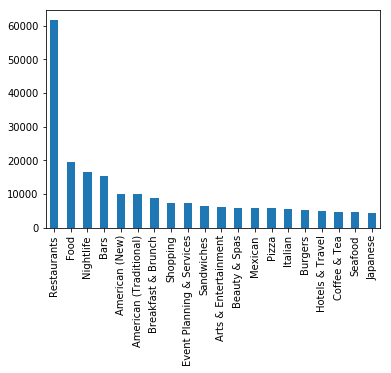

In [6]:
categories_df_head = categories_df.sum().sort_values(ascending=False)[:20]
categories_df_head.plot.bar()
plt.show()

In [7]:
threshold = 5000

# On garde : Restaurants, Bars, Shopping, Arts & Entertainment
business_types = {
    "Restaurants" : pd.DataFrame(), 
    "Bars" : pd.DataFrame(), 
    "Shopping" : pd.DataFrame(), 
    "Arts & Entertainment" : pd.DataFrame(), 
    "Hotels & Travel" : pd.DataFrame()
}

categories_df.loc[:,'Total'] = categories_df.sum(axis=1)

for business_type in business_types:
    review_ids = categories_df[categories_df[business_type]==1].sort_values(by=['Total'], ascending=True)[:threshold].index.values.tolist()
    df = data_df[data_df['review_id'].isin(review_ids)]
    business_types[business_type] = df
    

# Data processing

In [8]:
# Processing Functions
def identify_tokens(row):
    review = row['text']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    # token_words = [re.sub("[^\w\s]", " ", w) for w in tokens]
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['words']
    meaningful_words = [w for w in my_list if not w in stops and w != " "]
    return (meaningful_words)

stemming = PorterStemmer()

def stem_list(row):
    my_list = row['words_meaningful']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

lemming = WordNetLemmatizer()

def lem_list(row):
    my_list = row['words_meaningful']
    lemmed_list = [lemming.lemmatize(word) for word in my_list]
    return (lemmed_list)

def rejoin_words(row):
    my_list = row['stemmed_words']
    joined_words = ( " ".join(my_list))
    return joined_words

In [9]:
def process(data_df):
    data_df['text'] = data_df['text'].str.lower()
    data_df['words'] = data_df.apply(identify_tokens, axis=1)
    data_df['words_meaningful'] = data_df.apply(remove_stops, axis=1)
    data_df['stemmed_words'] = data_df.apply(stem_list, axis=1)
    data_df['lemmed_words'] = data_df.apply(lem_list, axis=1)
    data_df['processed'] = data_df.apply(rejoin_words, axis=1)
    return data_df

In [10]:
processed_business_types = {
    "Restaurants" : pd.DataFrame(), 
    "Bars" : pd.DataFrame(), 
    "Shopping" : pd.DataFrame(), 
    "Arts & Entertainment" : pd.DataFrame(), 
    "Hotels & Travel" : pd.DataFrame()
}

for business_type, df in business_types.items():
    df = process(df)
    processed_business_types[business_type] = df

/home/arthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/arthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/arthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# Post Processing Analysis

In [13]:
def analysis(data_df, title, words):
    all_words = sum(data_df[words], [])
    fdist = FreqDist(all_words)
    fdist.plot(30, cumulative=False, title=title)
    fdist.plot(100, cumulative=False, title=title)
    plt.show()

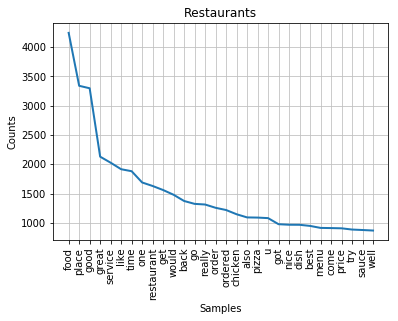

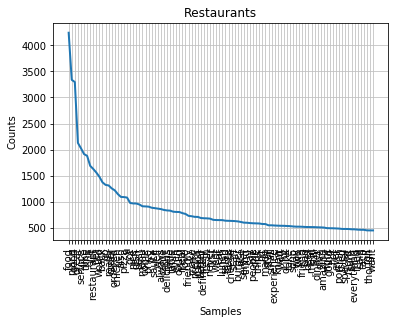

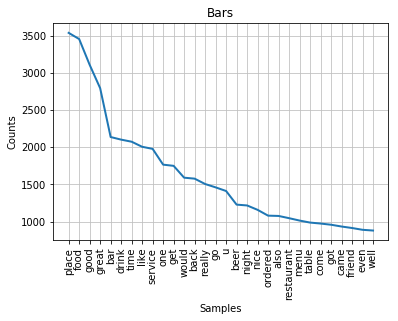

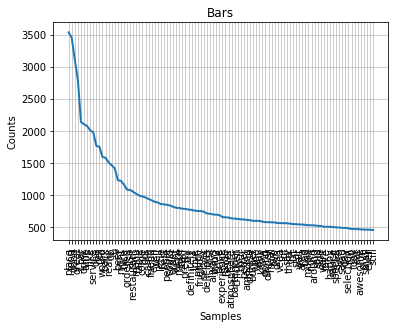

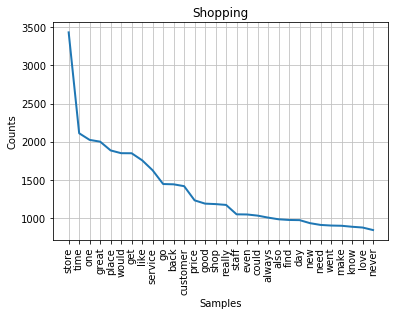

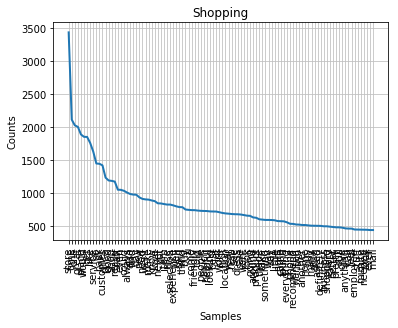

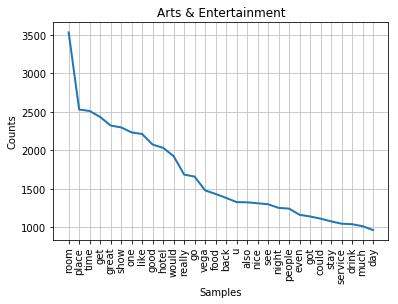

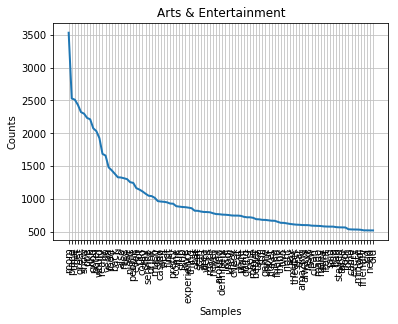

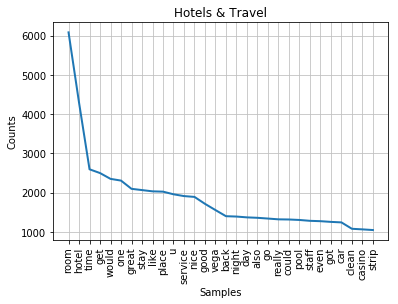

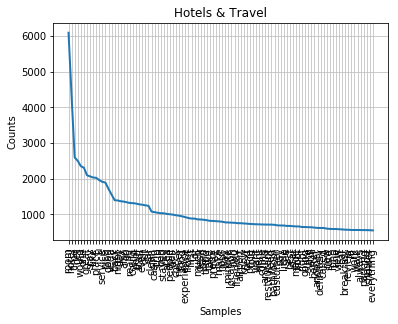

In [14]:
# use 'lemmed_words' or 'stemmed_words'
for business_type, df in processed_business_types.items():
    analysis(df, business_type, 'lemmed_words')

In [ ]:
all_lemmed_words = sum(data_df['lemmed_words'], [])
fdist_lem = FreqDist(all_lemmed_words)

In [ ]:
fdist_lem.plot(30,cumulative=True)
plt.show()